In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.model_zoo as model_zoo
import math
import numpy as np
from pytorch.mil import MIL, MILCriterion
from pytorch.data import get_training_set, get_test_set

In [2]:
# get the pretrained vgg16 weights

vgg16 = models.vgg16()
vgg16_features = next(vgg16.children())

In [3]:
# adapt first layer to handle 60 channels instead of 3
# take summed weights for 3 channels and split them over 60 channels for each position using dirichlet
# this might not work so well, might need to adapt more than just the first layer
old_in_channels = 3
new_in_channels = 60
out_channels = 64

old_first_layer = vgg16_features[0]
new_first_layer = nn.Conv2d(new_in_channels, out_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

for conv in range(out_channels):
    flat_conv = old_first_layer.weight[conv].sum(0)
    for x in range(3):
        for y in range(3):
            conv_redist = np.random.dirichlet(np.ones(new_in_channels), size=1)[0] *\
                          flat_conv[0, x, y].data.numpy()
            conv_redist = torch.from_numpy(conv_redist)
            new_first_layer.weight.data[conv, :, x, y] = conv_redist

new_features = [new_first_layer]
for i in range(1, 31):
    new_features += [vgg16_features[i]]
new_features = nn.Sequential(*new_features)


net = MIL(new_features)

In [4]:
trainset = get_training_set()
testset = get_test_set()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=1)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=1)

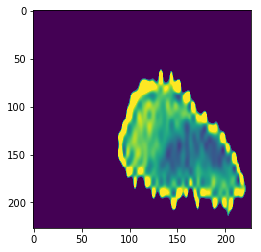

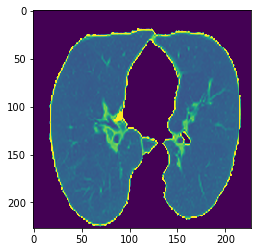

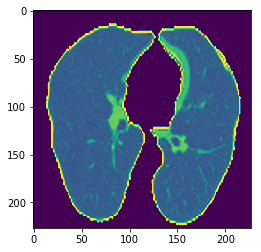

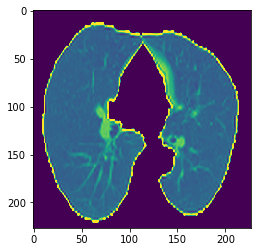


 1
[torch.DoubleTensor of size 1x1]
 
 0
[torch.DoubleTensor of size 1x1]
 
 1
[torch.DoubleTensor of size 1x1]
 
 0
[torch.DoubleTensor of size 1x1]



In [5]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    npimg = img.numpy()
    plt.imshow(npimg)
    plt.show()
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

for img in images:
    middle_slice = img[30]
    imshow(middle_slice)

print(' '.join('{label}'.format(label=labels[j]) for j in range(4)))

In [6]:
criterion = MILCriterion(.25, 1, cuda=True)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=.9)

In [10]:
net = net.cuda()
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.data[0]
        if i % 2000 == 1999:
            print('[{}, {}] loss: {}'.format(epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
print('finished training')

RuntimeError: CUDNN_STATUS_EXECUTION_FAILED